In [27]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout
from vit_flow import VITAttentionFlow
import requests
import torch.nn.functional as F
import torch.nn as nn

In [28]:
img = Image.open("examples/input.png")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE}")

IMAGE_SIZE = 224
DISCARD_RATIO = 0.9

def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()
model.to(DEVICE)

Using cuda


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

In [29]:
#@title Select the rollout strategy to be used and display results
#@markdown **Note** that for `grad_attention_rollout` passing a category index is mandatory.
rollout_strategy = "attention_flow" #@param ["attention_rollout", "grad_attention_rollout"]
category_index =  264#@param {type:"integer"}

print(f"Using {rollout_strategy}")

input_tensor  = preprocess_image("examples/input.png", transform)


Using attention_flow


100%|██████████| 197/197 [07:58<00:00,  2.43s/it]


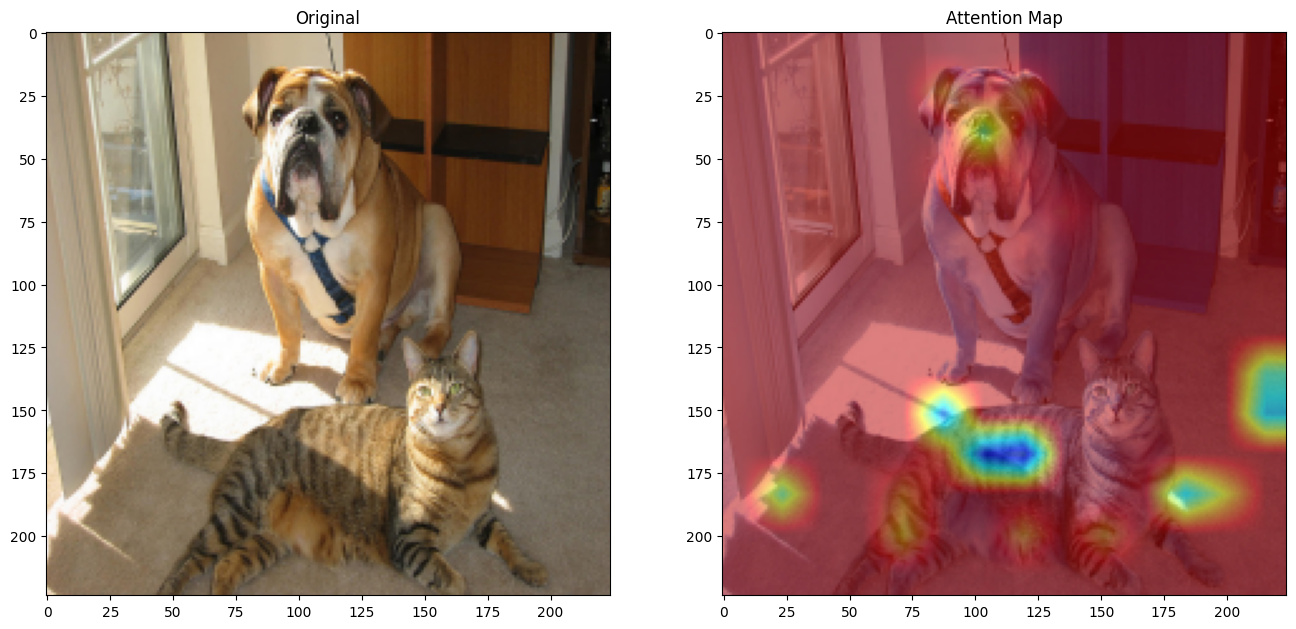

In [4]:
if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")
    
elif rollout_strategy == "attention_flow":
    attention_flow = VITAttentionFlow(model, discard_ratio=DISCARD_RATIO)
    mask = attention_flow(input_tensor)
    name = "attention_flow_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

# mask = (mask - mask.min()) / (mask.max() - mask.min())
# mask = mask.clip(0.7,1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)

In [30]:
img=Image.open("examples/plane.png")
#@title Select the rollout strategy to be used and display results
#@markdown **Note** that for `grad_attention_rollout` passing a category index is mandatory.
rollout_strategy = "attention_flow" #@param ["attention_rollout", "grad_attention_rollout"]
category_index =  264#@param {type:"integer"}

print(f"Using {rollout_strategy}")

input_tensor  = preprocess_image("examples/plane.png", transform)

Using attention_flow


100%|██████████| 197/197 [14:01<00:00,  4.27s/it]


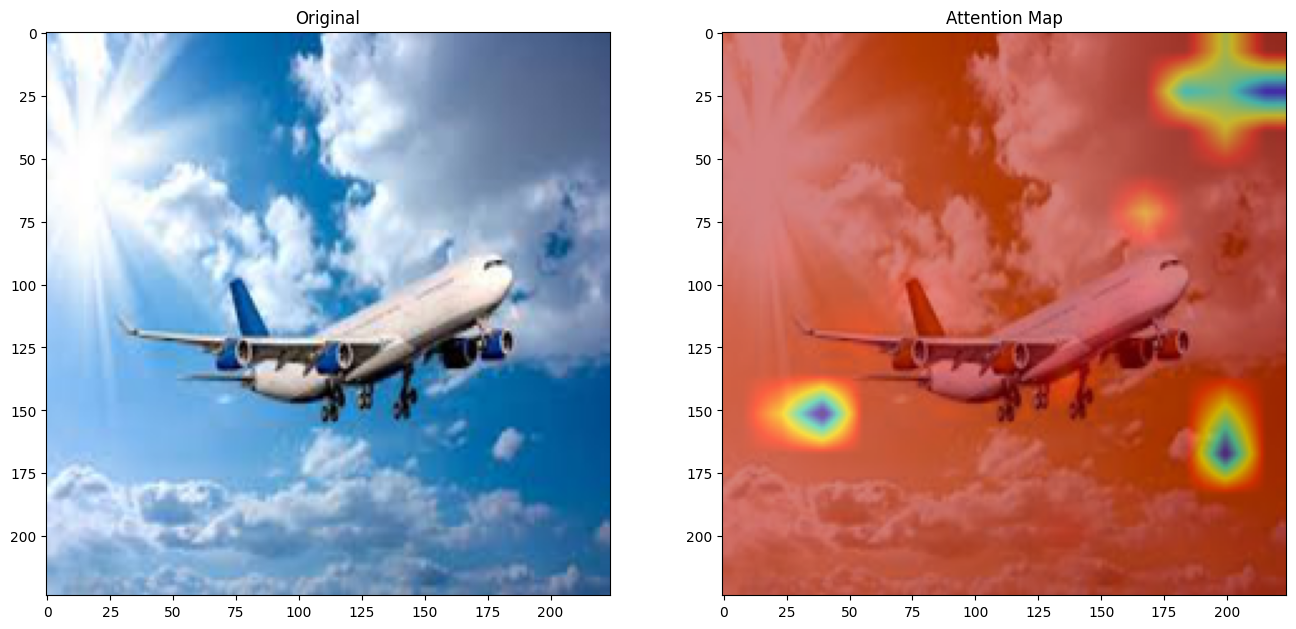

In [6]:


if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")
    
elif rollout_strategy == "attention_flow":
    attention_flow = VITAttentionFlow(model, discard_ratio=DISCARD_RATIO)
    mask = attention_flow(input_tensor)
    name = "attention_flow_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

# mask = (mask - mask.min()) / (mask.max() - mask.min())
# mask = mask.clip(0.7,1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)

## Attacks on the model
--------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------

In [31]:
#Checking simple predictions of the model
LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
classes = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

scores = model(input_tensor)

In [32]:


def print_preds(scores):
    # print the predictions with their 'probabilities' from the scores
    scores=scores.cpu()
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    # output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    return idx

_ = print_preds(scores)

0.304 -> ['n02690373', 'airliner']
0.084 -> ['n02692877', 'airship']
0.057 -> ['n04592741', 'wing']
0.055 -> ['n04552348', 'warplane']
0.034 -> ['n04266014', 'space_shuttle']


### Fast Gradient Sign Method Attack

In [33]:
#performing fgsm attack
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    grad_sign = torch.sign(data_grad)

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * grad_sign

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

idx = 656 #minivan
criterion = nn.CrossEntropyLoss()
input_tensor.requires_grad = True
scores = model(input_tensor)
scores=scores.cpu()
target = torch.tensor([idx])

#TODO: compute the loss to backpropagate
loss = criterion(scores, target)
loss.backward()

_ = print_preds(scores)

0.304 -> ['n02690373', 'airliner']
0.084 -> ['n02692877', 'airship']
0.057 -> ['n04592741', 'wing']
0.055 -> ['n04552348', 'warplane']
0.034 -> ['n04266014', 'space_shuttle']


## Massive adversaries on differents images

### Notes sur les attaques

attaquer les zones ou les attentions sont concentrées

faire une boucle for et attaquer jusqu'a ce que la première prédiction change

prendre une matrice de bruit.
comparer par rapport aux méthodes

faire un rank de quels blocs est plus susceptible aux attaques???


fixer une zone initiale et faire

In [34]:
def get_best_prediction(scores):
    scores=scores.cpu()
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    return  classes[idx[0]]#, probs[idx[0]]  #get the highest score

def fgsm_attack(image, epsilon, data_grad):
    grad_sign = torch.sign(data_grad)

  
    mask = torch.ones(224, 224, device=image.device)
    #mask[130:175, 25:50] = 0 #mask the first attention map
    #mask[0:30, 175:] = 0 #mask the second attention map
    #mask[150:175, 180:220] = 0 #mask the third attention map
    mask[0:75, 0:75] = 0
    

    perturbed_image = image + epsilon * grad_sign * mask

    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

eps=0.01

def compute_one_attack(x_img,data_grad,epsilon=eps):
    return fgsm_attack(x_img,epsilon,data_grad)
    
def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)


def preprocess_tensor(image):
    
    return image.to(DEVICE)

image prediction ['n02690373', 'airliner']
Class changed after 2 attacks.
['n01608432', 'kite']


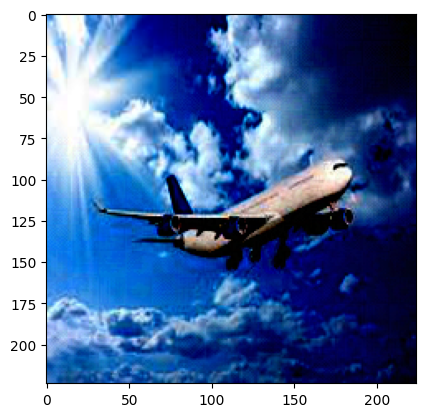

In [35]:
idx_target=265

def multiple_attacks(image,idx, thresold=200):
    attack_number = 0
    img_tensor = preprocess_image("examples/plane.png", transform)
    img_tensor = img_tensor.requires_grad_(True)  # Ensure img_tensor is a leaf variable
    assumption = True
    scores = model(img_tensor)
    my_pred = get_best_prediction(scores)
    print("image prediction", my_pred)
    target = torch.tensor([idx]).to(DEVICE).long()
    criterion = nn.CrossEntropyLoss()
    loss = criterion(scores, target)
    loss.backward(retain_graph=True)  # Backpropagate the loss
    data_grad = img_tensor.grad.data
    

    while attack_number < thresold and assumption:
        
        model.zero_grad()
        img_tensor = compute_one_attack(img_tensor, data_grad)
        attack_number += 1
        criterion = nn.CrossEntropyLoss()
        img_tensor = img_tensor.requires_grad_(True)  # Ensure img_tensor is a leaf variable
        target = torch.tensor([idx]).to(DEVICE).long()
        scores = model(img_tensor)
        loss = criterion(scores, target)
        loss.backward(retain_graph=True)  # Backpropagate the loss
        #data_grad = img_tensor.grad.data
        new_best_prediction = get_best_prediction(scores)
        #print(new_best_prediction)
        if new_best_prediction == my_pred : #['n02692877', 'airship']
            assumption = True
        else:
            assumption = False

    print("Class changed after", attack_number, "attacks.")
    print( new_best_prediction)

    reshaped_image = np.squeeze(img_tensor.detach().cpu().numpy())
    reshaped_image = np.transpose(reshaped_image, (1, 2, 0))
    plt.imshow(np.array(reshaped_image))

    return attack_number,new_best_prediction[1]

a,new_best_prediction=multiple_attacks(input_tensor,idx_target)


### ETUDE DE L'IMPORTANCE DU TARGET LORS DE L'ATTAQUE

On varie le target sur l'image et on note l'évolution du nombre d'attaque pur changer la classe 

In [36]:
word="airliner"
a=404
print("corresponding index {404}")

corresponding index {404}


Attaque sur les voisinages du vrai label
On fait varier les cibles sur les index voisins du vrai label

Target class: ['n02640242', 'sturgeon']
image prediction ['n02690373', 'airliner']
Class changed after 2 attacks.
['n04552348', 'warplane']
-----------------
Target class: ['n02641379', 'gar']
image prediction ['n02690373', 'airliner']
Class changed after 4 attacks.
['n04552348', 'warplane']
-----------------
Target class: ['n02643566', 'lionfish']
image prediction ['n02690373', 'airliner']
Class changed after 3 attacks.
['n02692877', 'airship']
-----------------
Target class: ['n02655020', 'puffer']
image prediction ['n02690373', 'airliner']
Class changed after 2 attacks.
['n04552348', 'warplane']
-----------------
Target class: ['n02666196', 'abacus']
image prediction ['n02690373', 'airliner']
Class changed after 3 attacks.
['n02692877', 'airship']
-----------------
Target class: ['n02667093', 'abaya']
image prediction ['n02690373', 'airliner']
Class changed after 2 attacks.
['n04552348', 'warplane']
-----------------
Target class: ['n02669723', 'academic_gown']
image prediction ['n0

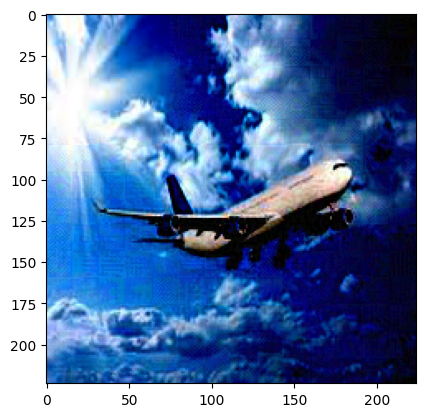

In [37]:
target_range=np.arange(a-10,a+10)
number_of_attacks=[]
for i in target_range:
    print("Target class:",classes[i])
    a,new_best_prediction=multiple_attacks(input_tensor,i)
    number_of_attacks.append(a)
    print("-----------------")


In [38]:
word="airliner"
for i in range(1000):
    if classes[i][1]==word:
        a=i
        break

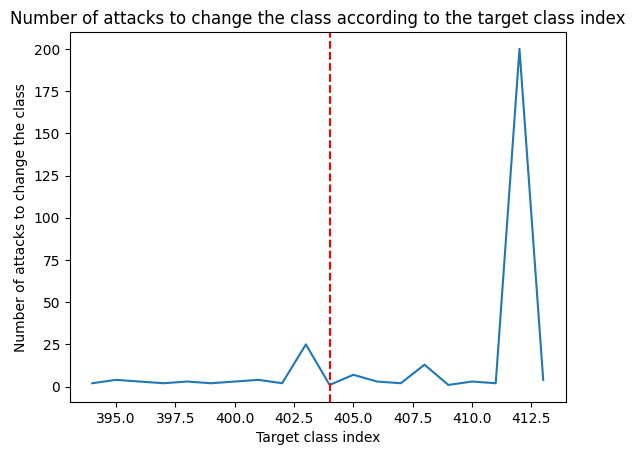

In [39]:
plt.plot(target_range,number_of_attacks)
plt.axvline(x=a, color='r', linestyle='--')
plt.xlabel('Target class index')
plt.ylabel('Number of attacks to change the class') 
plt.title('Number of attacks to change the class according to the target class index')
plt.show()    

Distance between words

Les mots étant ordonnés alphabétiquement, on voit que les mots à cote de laprdiction sont très proche de lui sémantiquement.
On constate que celà nécessite moins d'attaque pour changer la classe de l'image.
Nous allons vérifier celà en filtrant les mots étant dans le meme contexte et en les comparant avec les mots étant dans un contexte différent.


In [40]:
word="airliner"

target =["airship","aircraft_carrier","wing","warplane","space_shuttle","steel_arch_bridge"]
target_index=[]
for i in range(1000):
    if classes[i][1] in target:
        target_index.append(i)
        
       
#print(target_index)

Target class: ['n02687172', 'aircraft_carrier']
image prediction ['n02690373', 'airliner']
Class changed after 25 attacks.
['n02782093', 'balloon']
-----------------
Target class: ['n02692877', 'airship']
image prediction ['n02690373', 'airliner']
Class changed after 7 attacks.
['n07745940', 'strawberry']
-----------------
Target class: ['n04266014', 'space_shuttle']
image prediction ['n02690373', 'airliner']
Class changed after 3 attacks.
['n04552348', 'warplane']
-----------------
Target class: ['n04311004', 'steel_arch_bridge']
image prediction ['n02690373', 'airliner']
Class changed after 1 attacks.
['n04552348', 'warplane']
-----------------
Target class: ['n04552348', 'warplane']
image prediction ['n02690373', 'airliner']
Class changed after 11 attacks.
['n04311004', 'steel_arch_bridge']
-----------------
Target class: ['n04592741', 'wing']
image prediction ['n02690373', 'airliner']
Class changed after 2 attacks.
['n04266014', 'space_shuttle']
-----------------


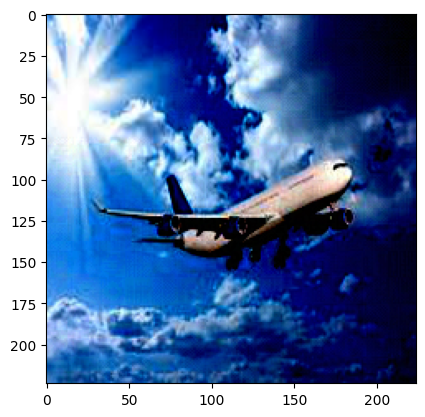

In [41]:

number_of_attacks=[]
new_classes=[]
for i in target_index:
    print("Target class:",classes[i])
    a,new_best_prediction=multiple_attacks(input_tensor,i)
    number_of_attacks.append(a)
    new_classes.append(new_best_prediction)
    print("-----------------")


In [42]:
new_classes

['balloon',
 'strawberry',
 'warplane',
 'warplane',
 'steel_arch_bridge',
 'space_shuttle']

In [43]:
word="airliner"

target =["great_white_shark","electric_ray","magpie","spotted_salamander","green_mamba"]
target_index=[]
for i in range(1000):
    if classes[i][1] in target:
        target_index.append(i)
        print(i,classes[i])
       
#print(target_index)

2 ['n01484850', 'great_white_shark']
5 ['n01496331', 'electric_ray']
18 ['n01582220', 'magpie']
28 ['n01632458', 'spotted_salamander']
64 ['n01749939', 'green_mamba']


Target class: ['n01484850', 'great_white_shark']
image prediction ['n02690373', 'airliner']
Class changed after 4 attacks.
['n02692877', 'airship']
------
Target class: ['n01496331', 'electric_ray']
image prediction ['n02690373', 'airliner']
Class changed after 5 attacks.
['n04266014', 'space_shuttle']
------
Target class: ['n01582220', 'magpie']
image prediction ['n02690373', 'airliner']
Class changed after 4 attacks.
['n07745940', 'strawberry']
------
Target class: ['n01632458', 'spotted_salamander']
image prediction ['n02690373', 'airliner']
Class changed after 1 attacks.
['n04266014', 'space_shuttle']
------
Target class: ['n01749939', 'green_mamba']
image prediction ['n02690373', 'airliner']
Class changed after 4 attacks.
['n04275548', 'spider_web']
------


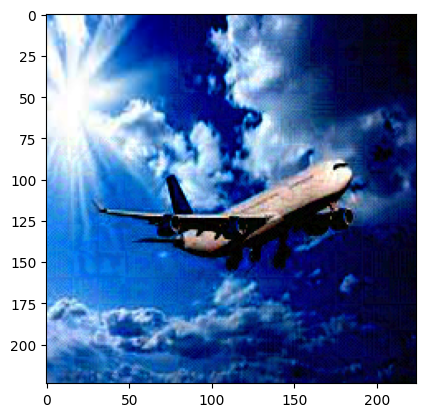

In [44]:
number_of_attacks_bis=[]
for i in target_index:
    print("Target class:",classes[i])
    a,new_best_prediction=multiple_attacks(input_tensor,i)
    number_of_attacks_bis.append(a)
    print("------")

Nouvelle idée: trouver l'accuracy du modèle en fonction du epsilon
On considère comme vraie prédiction la prédiction avant le changement de classe

Multiple attack on different images

In [71]:
threshold=200
def multiple_attacks_multiple_image(file,idx, thresold=200):
    attack_number = 0
    img_tensor = preprocess_image(file, transform)
    img_tensor = img_tensor.requires_grad_(True)  # Ensure img_tensor is a leaf variable
    assumption = True
    scores = model(img_tensor)
    my_pred = get_best_prediction(scores)
    print("image prediction", my_pred)
    target = torch.tensor([idx]).to(DEVICE).long()
    criterion = nn.CrossEntropyLoss()
    loss = criterion(scores, target)
    loss.backward(retain_graph=True)  # Backpropagate the loss
    data_grad = img_tensor.grad.data
    

    while attack_number < thresold and assumption:
        
        model.zero_grad()
        img_tensor = compute_one_attack(img_tensor, data_grad)
        attack_number += 1
        criterion = nn.CrossEntropyLoss()
        img_tensor = img_tensor.requires_grad_(True)  # Ensure img_tensor is a leaf variable
        target = torch.tensor([idx]).to(DEVICE).long()
        scores = model(img_tensor)
        loss = criterion(scores, target)
        loss.backward(retain_graph=True)  # Backpropagate the loss
        #data_grad = img_tensor.grad.data
        new_best_prediction = get_best_prediction(scores)
        #print(new_best_prediction)
        if new_best_prediction == my_pred : #['n02692877', 'airship']
            assumption = True
        else:
            assumption = False

    print("Class changed after", attack_number, "attacks.")
    print( new_best_prediction)

    reshaped_image = np.squeeze(img_tensor.detach().cpu().numpy())
    reshaped_image = np.transpose(reshaped_image, (1, 2, 0))
    plt.imshow(np.array(reshaped_image))

    return attack_number,new_best_prediction[1]


In [72]:
import os

def get_files_in_folder(folder_path):
    file_paths = []
    if os.path.isdir(folder_path):
        # Iterate through all files in the directory
        for file_name in os.listdir(folder_path):
            # Construct the full path to the file
            file_path = os.path.join(folder_path, file_name)
            # Check if the path points to a file (not a directory)
            if os.path.isfile(file_path):
                file_paths.append(file_path)
    return file_paths


folder_path = 'images'
file_paths_list = get_files_in_folder(folder_path)

def get_all_best_predictions(image_path_list):
    best_predictions = []
    for image_path in image_path_list:
        input_tensor = preprocess_image(image_path, transform)
        scores = model(input_tensor)
        max_pred=get_best_prediction(scores)[1]
        best_predictions.append(max_pred)
    return best_predictions

def get_best_prediction_after_attack(image_path_list, target_index):
    best_predictions_after_attack = []
    for image_path in image_path_list:
        input_tensor = preprocess_image(image_path, transform)
        a,new_best_prediction=multiple_attacks_multiple_image(image_path,target_index)
        best_predictions_after_attack.append(new_best_prediction)
       

    return best_predictions_after_attack    



In [73]:
file_paths_list=file_paths_list[:30]


In [74]:

best_pred=get_all_best_predictions(file_paths_list)


In [75]:
best_pred

['water_snake',
 'ski',
 'Shetland_sheepdog',
 'soup_bowl',
 'bassinet',
 'garter_snake',
 'porcupine',
 'gibbon',
 'mousetrap',
 'Maltese_dog',
 'brain_coral',
 'cougar',
 'guenon',
 'recreational_vehicle',
 'harvester',
 'grey_whale',
 'goldfish',
 'kite',
 'carton',
 'crane',
 'marmoset',
 'Saluki',
 'Granny_Smith',
 'planetarium',
 'vulture',
 'table_lamp',
 'white_wolf',
 'Walker_hound',
 'green_mamba',
 'birdhouse']

image prediction ['n01737021', 'water_snake']
Class changed after 1 attacks.
['n01665541', 'leatherback_turtle']
image prediction ['n04228054', 'ski']
Class changed after 3 attacks.
['n09193705', 'alp']
image prediction ['n02105855', 'Shetland_sheepdog']
Class changed after 1 attacks.
['n02102177', 'Welsh_springer_spaniel']
image prediction ['n04263257', 'soup_bowl']
Class changed after 1 attacks.
['n07920052', 'espresso']
image prediction ['n02804414', 'bassinet']
Class changed after 1 attacks.
['n02834397', 'bib']
image prediction ['n01735189', 'garter_snake']
Class changed after 1 attacks.
['n09421951', 'sandbar']
image prediction ['n02346627', 'porcupine']
Class changed after 200 attacks.
['n02346627', 'porcupine']
image prediction ['n02483362', 'gibbon']
Class changed after 1 attacks.
['n04116512', 'rubber_eraser']
image prediction ['n03794056', 'mousetrap']
Class changed after 200 attacks.
['n03794056', 'mousetrap']
image prediction ['n02085936', 'Maltese_dog']
Class changed afte

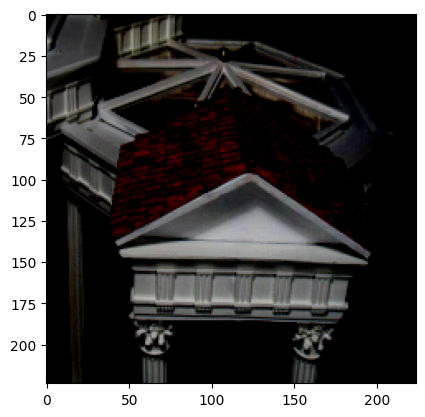

In [76]:

threshold=200
best_pred_after_attack=get_best_prediction_after_attack(file_paths_list, idx_target)


In [77]:
best_pred_after_attack

['leatherback_turtle',
 'alp',
 'Welsh_springer_spaniel',
 'espresso',
 'bib',
 'sandbar',
 'porcupine',
 'rubber_eraser',
 'mousetrap',
 'Pekinese',
 'brain_coral',
 'dingo',
 'tiger',
 'ambulance',
 'rapeseed',
 'leatherback_turtle',
 'spider_web',
 'black_stork',
 'desk',
 'crane',
 'howler_monkey',
 'ballplayer',
 'Granny_Smith',
 'planetarium',
 'vulture',
 'lampshade',
 'timber_wolf',
 'beagle',
 'green_mamba',
 'dishwasher']

In [80]:
def accuracy_prediction_after_attack(best_pred,best_pred_after_attack):
    count=0
    for i in range(len(best_pred)):
        if best_pred[i]!=best_pred_after_attack[i]:
            count+=1
    return count/len(best_pred)

In [81]:
print("The accuracy of the model after attack is",accuracy_prediction_after_attack(best_pred,best_pred_after_attack)*100,"% for max_iter=200")

The accuracy of the model after attack is 73.33333333333333 % for max_iter=200


On va étudier l'impact de max_iter sur l'accuracy de la prédiction après attaque

In [ ]:
thresold_range=np.arange(100,300,10)
accuracy=[]
for i in thresold_range:
    thr
